# <center>  Feature scaling and linear regression with multiple variables </center>

## Feature scaling

Before we begin properly with multivariate linear regression, let's just quickly go through how easily you can standardize data (feature scaling) in scikit learn.

Standardization of datasets is a common requirement for many machine learning estimators; they might behave badly if the individual features do not more or less look like standard normally distributed data: that is, Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing each feature by its standard deviation.

Many elements used in the objective/loss/error function of a learning algorithm in scikit-learn assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

The function `scale` in scikit-learn provides a quick and easy way to perform this operation on a single array-like dataset. Observe how we create a feature matrix $X$ where the different features $x_1$, $x_2$, $x_3$ differ widely in their range/scale. $x_1$ for instance oscillates between 1000 and 1500 while $x_3$ oscillates between -0.03 and 0.07. 

In [1]:
from sklearn import preprocessing
import numpy as np

np.set_printoptions(suppress=True) #line to prettify the output of numpy arrays so they are not ridiculously long
X = np.array([[ 1000, -1,  0.02],
              [ 1500,  2,  0.07],
              [ 1290,  1.5, -0.03]])
X_scaled = preprocessing.scale(X)
print(X_scaled  )

[[-1.2845953  -1.3970014  -0.        ]
 [ 1.1545097   0.88900089  1.22474487]
 [ 0.1300856   0.50800051 -1.22474487]]


By preprocessing the data in $X$ we get a transformed features matrix $X_{scaled}$ where each column has a mean of 0 and a standard deviation of 1 while still conserving the information contained in the original features matrix $X$. 

In [2]:
print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

[ 0. -0.  0.]
[1. 1. 1.]


The `preprocessing` module further provides a utility class `StandardScaler` that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [4]:
X_train = X #Let's assume we already split the data into training set and test set
scaler = preprocessing.StandardScaler().fit(X_train)
print(scaler.mean_)
print(scaler.scale_)

[1263.33333333    0.83333333    0.02      ]
[204.99322482   1.31233465   0.04082483]


The scaler instance can then be used on new data to transform it the same way it did on the training set:             

In [5]:
X_test = np.array([[ 1100, -2,  0.03],
              [ 1200,  0.3,  -0.04],
              [ 1050,  1.4, -0.01]])
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled) 

[[-0.7967743  -2.15900216  0.24494897]
 [-0.3089533  -0.40640041 -1.46969385]
 [-1.0406848   0.43180043 -0.73484692]]


This technique is important in order to prevent information from the test set creeping in into our model and leading it to over optimistic estimations of performance. By carrying out feature scaling using only the information contained in the training set, we prevent the infiltration of information from the test data into the model.

## Multivariate linear regression

### Loading data

We will work with data derived from the "Parkinsons Telemonitoring" dataset of the University of Oxford (https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring).  The original study used a range of linear regression methods to predict a clinician's diagnosis of Parkinson's disease symptom using a score on the UPDRS scale. The original dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. The original data contains subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 other biomedical voice features. 

We will work with a reduced data set containing just 3 columns: Voice feature 1 (ratio of noise to tonal components in the voice), Voice feature 2 (fundamental frequency variation) and a clinician score of the patient symptoms. Specifically, we will study how the Voice features: Voice feature 1 ($x_1$) and Voice feature 2 ($x_2$) can be used to predict the clinician score of the patient's symptoms ($y$). That is, we want to find the parameters $\theta_0$, $\theta_1$ and $\theta_2$ of the following multivariate linear regression model, so we can in the future predict, using just the voice derived features of a patient, how a clinician would rank the status of that Parkinson's patient. 

$$y=h_\theta (x)= \theta_0 + \theta_1x_1 + \theta_0x_2$$

In other words, in this notebook you will be creating some sort of artificial doctor, who is capable of looking at a couple of voice features from a given patient and predict how severe the stage of the Parkinson's disease is on the given patient. Obviously, we will want our system to be as good or better than a real doctor in properly assessing the degree of Parkinson's disease on a given patient. The baseline of real doctors diagnosis is contained in $y$.

We begin by loading the dataset "Parkinsons Telemonitoring" using the numpy `loadtxt` function. 

In [2]:
import numpy as np
data = np.loadtxt("data/artifical_lin.txt")
data

array([[0.00747581, 0.43208362, 1.45054918],
       [0.49910584, 0.20943748, 1.1025327 ],
       [0.11935362, 0.59634898, 1.33827336],
       ...,
       [0.10372845, 0.68081171, 2.05117861],
       [0.71603521, 0.51603214, 2.13485233],
       [0.42206812, 0.22973643, 0.62270978]])

The data contained in the file `artifical_lin.txt` has already been normalized/standardized/features scaled. The data file contains 3 columns, The 1st two represent the voice features and the 3rd one is the clinician score ($y$). That is, $X$ and $y$ are mixed in this file. We want to work now with 2-dimensional data (voice feature 1 and voice feature 2), in order to visualize the data in 3D space by plotting it. Therefore we will select 2 columns (attributes/features/predictors), "Voice feature 1" and "Voice feature 2", which are the 1st and 2nd columns in the data file. The target (clinician score of the patient symptoms) is located in the 3rd column of the original data file and it will be stored in vector $y$.

In [3]:
X = data[:, :-1] # select all the rows [:, in the data object and all the columns except the last one ,:-1
y = data[:, -1] # select all the rows in the last column of the data object
print(X[:10, :])
print(y[:10])

[[0.00747581 0.43208362]
 [0.49910584 0.20943748]
 [0.11935362 0.59634898]
 [0.47691878 0.91091956]
 [0.73039367 0.88576849]
 [0.96646013 0.75029941]
 [0.0254202  0.74285026]
 [0.17781366 0.59303845]
 [0.44925923 0.89314114]
 [0.08370431 0.26143735]]
[1.45054918 1.1025327  1.33827336 2.6022192  2.2101526  2.6110778
 1.71069895 2.23335293 3.10281928 0.86406978]


We shuffle the examples which is a standard of good practice:

In [4]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=1)
print(X.shape)
print(y.shape)

(500, 2)
(500,)


Now we split the data into train and test set:

In [5]:
train_set_size = int(X.shape[0] / 2 )
print(train_set_size)
X_train = X[:train_set_size, :]  # selects first train_set_size rows (examples) for train set
X_test = X[train_set_size:, :]   # selects from row train_set_size until the last one for test set
print(X_train.shape)
print(X_test.shape)

250
(250, 2)
(250, 2)


And we split the targets $y$ into train and test set in similar way as we splitted data $X$:

In [8]:
y_train = y[:train_set_size]   # selects first 15 rows (targets) for train set
y_test = y[train_set_size:]    # selects from row 250 until the last one for test set
print(y_train.shape)
print(y_test.shape)

(250,)
(250,)


A more convenient way of achieving the same functionality (splitting the original data into a train and test sets) is to use the convenient `train_test_split` function within `scikit-learn`.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5) #50% of the data in training set and 50% of the data in test set

Let's look at the data in a 3D plot. Notice the existence of a linear relationship in the data (as voice feature 2 increases in value, so does the clinician score in a gradual/linear fashion).

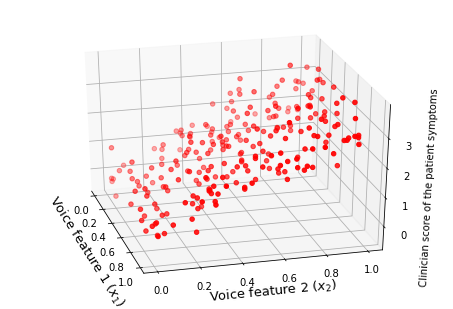

In [12]:
%matplotlib inline 
#Remember, you do need to include the previous line if you're working in the Spyder interpreter
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train[:],c='r')
ax.view_init(29,-15) #specifying the position in space from which we look at the data (i.e. perspective)

plt.xlabel(r'Voice feature 1 ($x_1$)',size=13)
plt.ylabel(r'Voice feature 2 ($x_2$)',size=13)
ax.set_zlabel('Clinician score of the patient symptoms')
plt.show()

Since we are working in 3 dimensions, it might be useful to change the perspective from which we look at the data.

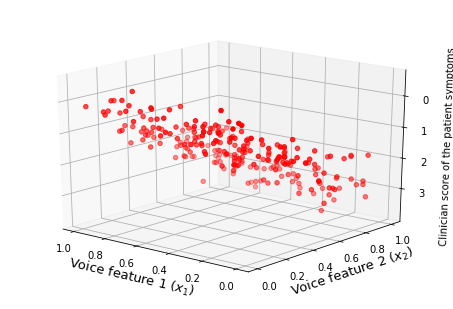

In [16]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train[:],c='r')

ax.view_init(200,50) #specifying the position in space from which we look at the data

plt.xlabel(r'Voice feature 1 ($x_1$)',size=13)
plt.ylabel(r'Voice feature 2 ($x_2$)',size=13)
ax.set_zlabel('Clinician score of the patient symptoms')
plt.show()

You can probably tell yourself that the data is relatively linear with no apparent nonlinear relationship between the voice features and the clinician score. Hence, using linear regression to create a model is appropriate.

### Creating a Linear regression model/estimator

Let's create a linear regression object, which we will subsequently fit to our data:

In [18]:
from sklearn import linear_model
model = linear_model.LinearRegression()

We fit the model to the training set. That is, estimate the optimal parameters $\theta_0$, $\theta_1$ and $\theta_2$ that minimize the offset between the training points and the hyperplane defined by the $\theta_ns$. Notice that this time we are carrying out **multivariate** linear regression, since the training data contained in $X$ has 2 columns.

In [23]:
model.fit(X_train, y_train);

That's it! The optimal model has been estimated. It's parameters are:

In [27]:
model.intercept_ # theta0

0.07664238757604913

In [28]:
model.coef_ # theta1,  theta2

array([-0.00503171,  3.06135565])

But..., how good is our model? how should we evaluate our results? There are several measures that can be used (you can look at the list of functions under the `sklearn.metrics` module). The most common for linear regression is the **$R^2$** score, or **coefficient of determination** that measures the proportion of the outcomes (**$y$**) variation explained by the model, and is the default score function for regression methods in `scikit-learn`. This score reaches its maximum value of 1 when the model perfectly predicts all the test target values (**$y_{test}$**).

In [29]:
print(model.score(X_test, y_test))

0.8098151181321932


This means our model explains 83% (0.83*100) of the variance contained in the training data (which is pretty good). That is, the clinician score ($y$) is determined in 83% by the voice features ($x_1$ and $x_2$). The remaining 18% variance is probably due to noise or other predictor factors (additional features) which are not contained in our input data matrix $X$. In any case, it is quite remarkable that we can approach a clinician estimation of disease severity using just 2 simple features derived from the voice of the patient. 

Recall that we can easily access the coefficients and the bias (the intercept) of our multivariate linear regression model. Notice that since we are working with bivariate linear regression, we have 2 coefficients $\theta_1$ and $\theta_2$ (slopes in each dimension) and one intercept $\theta_0$.

In [30]:
print(model.coef_) #\theta1 and theta2
print(model.intercept_)  #theta_0

[-0.00503171  3.06135565]
0.07664238757604913


Notice how the 2nd  feature of the model weighted by the $\theta_2$ parameter seems to have a higher weight/impact on the target $y$ as indicated by the fact that $\theta_2 > \theta_1$. Specifically, for each unit of increase in future 2, the clinician score increases by 3 units. You can probably notice that in the 3D plots above. Obviously, in higher dimensional spaces, you could not visualize such a pattern and the quantification of the parameters $\theta_n$ provided by linear regression becomes very useful.

Next we calculate the mean square error on the training and test sets. This is the value of the cost function $J(\theta_0,\theta_1,\theta_2)$ at the optimal parameters $\theta_0$, $\theta_1$ and $\theta_2$. Remember that the cost function is calculated by summing all the differences between each prediction of the model and the actual value $y$ in the test set.

$$J(\theta_0,\theta_1,\theta_2)=\frac{1}{2m}\sum_{k=1}^m(h_\theta(x_i)-y_i)^2)$$

In [31]:
# The mean square error
print("Mean squared error on training set: ", np.mean((model.predict(X_train) - y_train) ** 2))
print("Mean squared error on test set: ", np.mean((model.predict(X_test) - y_test) ** 2))

Mean squared error on training set:  0.14892901189054245
Mean squared error on test set:  0.17639900214592721


Using the Mean squared error is another form of quantifying how well your model is doing. However, this metric is not easy to compare across different problems and models that use features with different units. Hence, the $R^2$ score, or coefficient of determination is better as a universal way of quantifying how well our model is doing at predicting data not seen during training.

### Plotting data and linear model

Now we want to plot the training data (marked as red dots) and the hyperplane representing our linear model ($y=h_\theta (x)= \theta_0 + \theta_1x_1 + \theta_2x_2$) you have estimated using the training data. Is that model what allow us to carry out predictions in the test data and future data we might provide to the model for estimation of $y$. Don't worry about the specifics of the plotting code snippet. Focus on the visualization.

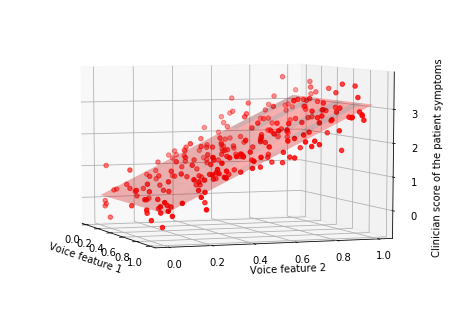

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train[:],c='r')    # plots 3d points, 500 is number of points which are visualized

# here we create plane which we want to plot, using the train data and predictions (you don't need to understand it)
range_x = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), num=10)
range_y = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), num=10)
xx, yy = np.meshgrid(range_x, range_y)
zz = np.vstack([xx.ravel(), yy.ravel()]).T
pred = model.predict(zz)
pred = pred.reshape(10, 10)
plt.xlabel('Voice feature 1')
plt.ylabel('Voice feature 2')
ax.set_zlabel('Clinician score of the patient symptoms')
ax.plot_surface(xx, yy, pred, alpha=.3,color='r')  # plots the plane
ax.view_init(6,-20)
plt.show()


The redish hyperplane is a visualization of your model. It's specific form is determined by the parameters $\theta_0$, $\theta_1$ and $\theta_2$. Now we plot the test data (green dots) and the model plane in a similar way:

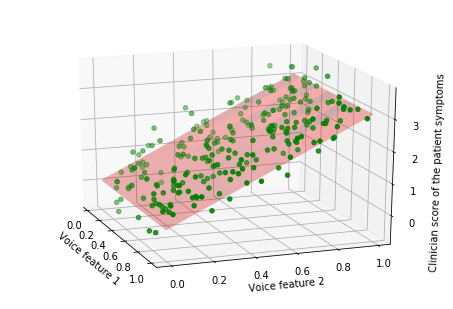

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X_test[:, 0], X_test[:, 1], y_test[:],c='g')    # plots 3d points 500 is number of points which are visualized

# here we create plane which we want to plot, using the train data and predictions (you don't need to understand the code)
range_x = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), num=10)
range_y = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), num=10)
xx, yy = np.meshgrid(range_x, range_y)
zz = np.vstack([xx.ravel(), yy.ravel()]).T
pred = model.predict(zz)
pred = pred.reshape(10, 10)
plt.xlabel('Voice feature 1')
plt.ylabel('Voice feature 2')
ax.set_zlabel('Clinician score of the patient symptoms')
ax.plot_surface(xx, yy, pred, alpha=.3,color='r')  # plots the plane
ax.view_init(20,-20)
plt.show()


To recap, you have used multivariate linear regression to create a model (hyperplane $h(x)$) that is able to approximate $y$ given $x_1$ and $x_2$. The parameters $\theta_0$, $\theta_1$, and $\theta_2$, were estimated to maximize the fitting of the model ($h_\theta (x)= \theta_0 + \theta_1x_1 + \theta_0x_2$) to the training data. To generate a prediction $y$ on a new patient with some values $x_1$ and $x_2$, You simply plug $x_1$ and $x_2$ in the model $h_\theta (x)$ and you will get a value $y$ corresponding to a point in the hyperplane. The value of $y$ is your model's prediction of the patient clinical score.

Let's say you want to test the performance of your model with a new patient. You record the voice of the patient and after some the digital processing of the audio signal you extract the 2 features of interest with values 0.4 and 0.9. How can you estimate the severity of the disease? you simply use your parameterized model:

In [34]:
model.predict([[0.4,0.9]]) 

array([2.82984979])

Since clinicians scores are in the range between 0 and 3, with larger values indicating higher severity, your machine learning model is predicting that this patient has a severe case of Parkinson. Given, the large $R^2$ of our model, a clinician would probably agree.

That's it! you have created your first AI-powered artificial Doctor.

### Polynomial regression using nonlinear transformations

One common pattern within machine learning is to use extended linear models trained on nonlinear data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of nonlinear data.
For example, a simple linear regression can be extended by constructing polynomial features derived from the original features. This will allow the model to be more flexible (wiggly) and fit data with nonlinear structure.

In the standard linear regression case, you might have a model (a line) that looks like this for one-dimensional data:

$${y} =h_{\theta}(x)= \theta_0 + \theta_1 x_1$$


This is a good time to recall that polynomials of different degrees can create functions of different shapes:

![](./images/pf.jpg)

If we want to fit a paraboloid (a U shaped curve) to the data instead of a hyperplane (a line in  2D), we can combine the feature $x_1$ into a second-order polynomial, so that the model looks like this:

$${y} = h_{\theta}(x)= \theta_0 + \theta_1 x_1 + \theta_2 x_1^2 $$

By considering linear fits within a higher-dimensional space built with these basis functions, the model has the flexibility to fit a much broader range of data. Let's generate some nonlinear data pattern to illustrate the concept:

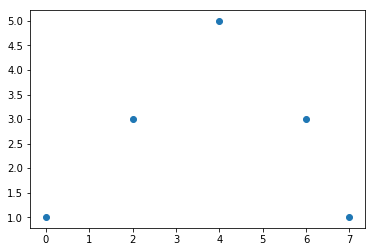

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
X = np.array([0,2,4,6,7])
y = np.array([1,3,5,3,1])
plt.scatter(X,y)

It should be clear to you that simple linear regression (trying to fit a line to the data points) wouldn't stand a chance. The data is not linear, so no single line would be able to do a good job at predicting y in the x range [0,7].  However, we can carry out a nonlinear transformation $\phi(x): [x,x^2]$ of the input feature $x$ to obtain a $2^{nd}$ degree polynomial: 

$${y} = h_{\theta}(x)= \theta_0 + \theta_1 x_1 + \theta_2 x_1^2 $$

In [36]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_transformed  = poly.fit_transform(X.reshape(-1,1))
X_transformed

array([[ 1.,  0.,  0.],
       [ 1.,  2.,  4.],
       [ 1.,  4., 16.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.]])

Notice the input data points in $X$ [0, 2, 4, 6, 7] as the second column of $X_{transformed}$ (the first column is just a filler for the intercept). The third column of $X_{transformed}$ is just the second column squared.

Next, we feed the nonlinearly transformed input matrix $X_{transformed}$ with the standard linear regression estimator:

In [37]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_transformed,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Finally, let's test the performance of our estimator on some new test data. Notice that we also need to apply the nonlinear transformation $\phi(x): [x,x^2]$ to the test data in order for the estimator to work properly.

In [39]:
X_test = np.array([1,3,5,8]) #New data points that our model didn't see during training
X_test_tranformed = poly.transform(X_test.reshape(-1,1))
y_predicted = model.predict(X_test_tranformed)
y_predicted

array([ 2.51942902,  4.3814433 ,  3.94686757, -1.0111023 ])

You should appreciate how good those predictions are. Let's plot the original training data in blue, and the test data in red. The y values of the test data (in red) have been predicted by our model. Notice how closely, the predictions (in red) approximate the ground truth target function present in the original training data (in blue).

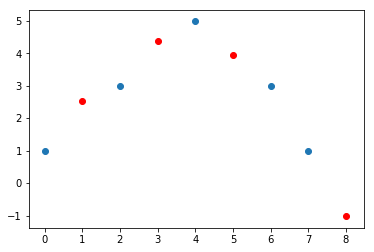

In [40]:
plt.scatter(X,y)
plt.scatter(X_test,y_predicted,color='red')

I hope you are able to appreciate the quite remarkable result you have obtained. You have basically used a **linear** model to fit a **nonlinear** target function using the clever trick of a nonlinear transformation of the input feature. Please talk to me if this is not clear to you.

The next example is a bit more elaborate. You don't need to understand the specifics of the code snippet. Simply appreciate the resulting figure below. The black dots represent your training data $X$, the black curve is your target function (which is usually unknown to you as a data scientist), the target function is usually the law that governs the generation of the data $X$ in the process you are trying to model). With a simple polynomial of degree 1 ($y=\theta_0+\theta_1x$) which is a line (in blue) the fit to the training data is obviously poor. Even a 3rd degree polynomial ($y=\theta_0+\theta_1x+\theta_2x^2+\theta_3x^3$), the orange curve, fits the data poorly. A 5th degree polynomial however, ($y=\theta_0+\theta_1x+\theta_2x^2+\theta_3x^3+\theta_4x^4+\theta_5x^5$), the green curve, fits the data nicely and approximates tightly the target function in black (ground truth).

Automatically created module for IPython interactive environment


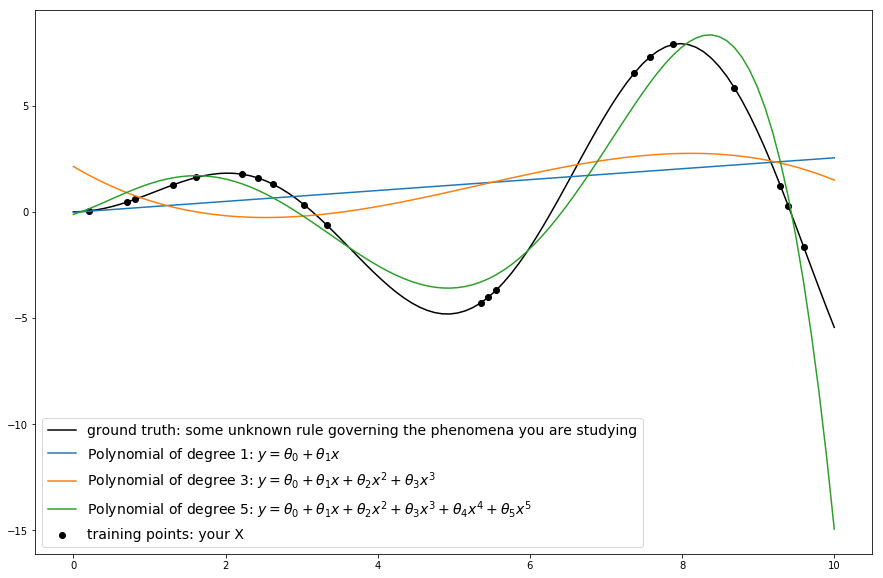

In [54]:
%matplotlib inline
print(__doc__)

# Modified from Mathieu Blondel and Jake Vanderplas
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

plt.figure(figsize=(15, 10))
# plt.figure(figsize=(40, 20), dpi=100)
plt.plot(x_plot, f(x_plot), label="ground truth: some unknown rule governing the phenomena you are studying",color='k')

plt.scatter(x, y, label="training points: your X", color='k')


for degree in [1, 3, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    if degree == 1:
        plt.plot(x_plot, y_plot, label=r'Polynomial of degree %d: $y=\theta_0+\theta_1x$' % degree)
    elif degree == 3:
        plt.plot(x_plot, y_plot, label=r'Polynomial of degree %d: $y=\theta_0+\theta_1x+\theta_2x^2+\theta_3x^3$' % degree)
    elif degree == 5:
        plt.plot(x_plot, y_plot, label=r'Polynomial of degree %d: $y=\theta_0+\theta_1x+\theta_2x^2+\theta_3x^3+\theta_4x^4+\theta_5x^5$' % degree)

plt.legend(loc='lower left',fontsize=14)
plt.show();

## Exercise 

> *<font color=blue>The following exercises is designed to provide you with a good feedback signal about how you are doing in the course so far. If you're able to complete the requirements, you're in good shape. If you struggle, please talk to me.</font>*

The following code loads the Boston House Pricing Dataset (http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). The dataset contains a total of 506 instances/samples/cases of houses in the Boston area and several descriptive features for each as well as the price at which they were sold in 1978. Your task will be to use the input features in $X$ to estimate the optimal parameters ($\theta_0 + \theta_1 + ... + \theta_{13}$) of a model ($h(x)$) that is able to predict the price ($y$) of a house given some input features ($x_1, x_2 ... , x_{13}$). Let's keep it simple and **don't** use a nonlinear transformation of the input features.

In [55]:
from sklearn.datasets import load_boston
boston = load_boston()
print (boston.keys())
print (boston.data.shape)
print (boston.feature_names)

dict_keys(['data', 'target', 'feature_names', 'DESCR'])
(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']



There are 13 attributes/features in each case of the dataset. 
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- B - $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population

The target property $y$ is the variable named 'boston' containing the price of the house in 1978 in thousands of dollars.

Examine the data structure named data in the variable Boston using Spyder's variable explorer and make sure you understand which are the features of the data and which are the targets.

1. Shuffle the data

2. Split the data into two halves: a training set and a test set and carry out multivariable linear regression on the training data (i.e. fit a hyperplane to the data) using all the features available 

3. What are the coefficients ($\theta_1, \theta_2,...\theta_{13}$) of the model? And the intercept ($\theta_0$)?

4. What is the mean squared error on the training set? and the test set?

5. What is the $R^2$ (coefficient of determination) of the training set? and the test set? Which one of the 2 is more relevant in terms of quantifying how well your model will do with unseen data (generalization capability) of your model

6. Use your model to predict the price of the 1st house on the test set. Compare that prediction with the actual price by which the house was sold.